### Importing Dependencies

In [246]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from warnings import filterwarnings
filterwarnings('ignore')

In [190]:
#importing the dataset
df = pd.read_csv('arduino_data.csv')
df.sample(5,ignore_index=True)

,timestamp,temp,humidity,ppm
0,2023-06-11T19:23:43+05:30,36,37,15.51
1,2023-06-15T06:50:04+05:30,39,33,54.15
2,2023-06-16T06:15:51+05:30,38,32,48.24
3,2023-06-14T08:36:58+05:30,40,33,62.31
4,2023-06-16T11:30:23+05:30,40,35,21.62


In [191]:
# convert 'timestamp' to a datetime object
df.timestamp = pd.to_datetime(df.timestamp)
# extract 'hour' from timestamp
df['hour'] = df.timestamp.dt.hour
df.sample(5,ignore_index=True)

,timestamp,temp,humidity,ppm,hour
0,2023-06-15 17:31:02+05:30,43,29,48.24,17
1,2023-06-14 00:50:45+05:30,40,28,54.15,0
2,2023-06-13 22:00:27+05:30,30,27,51.13,22
3,2023-06-13 19:08:23+05:30,44,21,75.31,19
4,2023-06-11 10:02:33+05:30,36,45,39.11,10


In [192]:
# extract 'weekend' based on the day in 'timestamp'
df.loc[df.timestamp.dt.day.isin([10,11,17]),'weekend'] = 1
df.weekend.fillna(0,inplace=True)
df.insert(5,'ppm',df.pop('ppm'))
df.drop('timestamp',axis=1,inplace=True)

### EDA and preprocessing

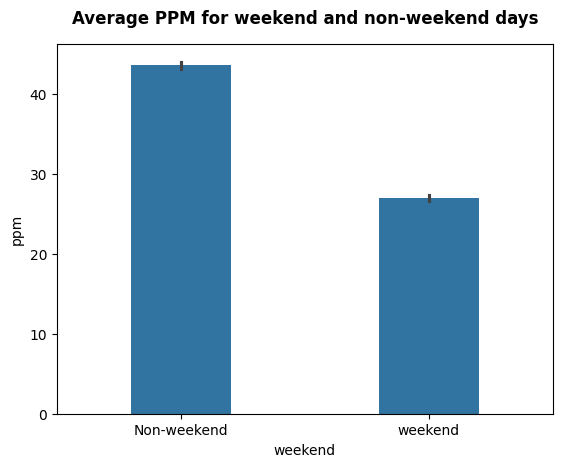

In [193]:
sns.barplot(x=df.weekend,y=df.ppm,width=0.4)
plt.title('Average PPM for weekend and non-weekend days',fontweight='bold',pad=15)
plt.xticks([0,1],['Non-weekend','weekend'])
plt.show()

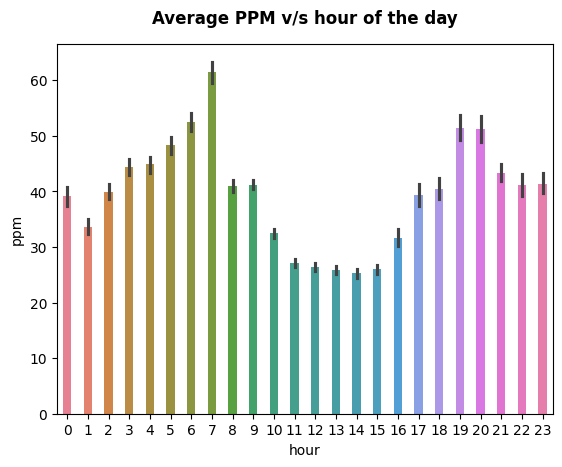

In [194]:
sns.barplot(x=df.hour,y=df.ppm,width=0.4,color='red',palette='husl')
plt.title('Average PPM v/s hour of the day',fontweight='bold',pad=15)
plt.show()

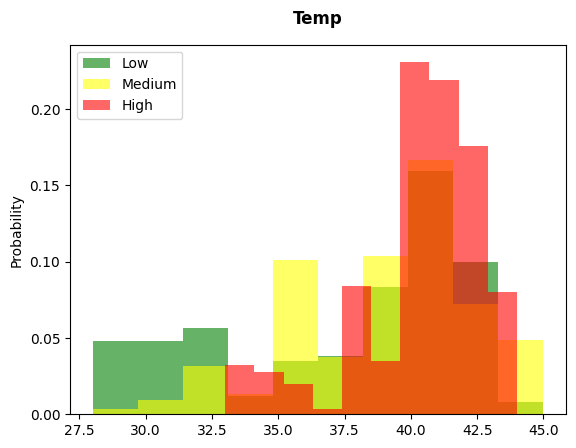

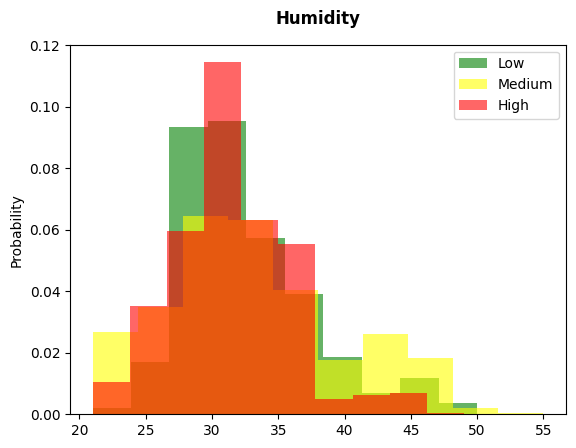

In [195]:
for label in df.columns[0:2]:
    plt.hist(df[(df.ppm>=0) & (df.ppm<35)][label],alpha=0.6,density=True,label='Low',color='green')
    plt.hist(df[(df.ppm>=35) & (df.ppm<70)][label],alpha=0.6,density=True,label='Medium',color='yellow')
    plt.hist(df[df.ppm>=70][label],alpha=0.6,density=True,label='High',color='red')
    plt.title(label.title(),fontweight='bold',pad=15)
    plt.ylabel('Probability')
    plt.legend()
    plt.show()

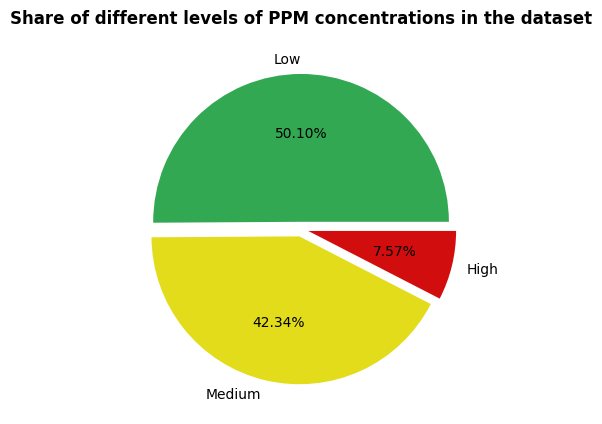

In [196]:
low_count=df.ppm[(df.ppm>=0) & (df.ppm<35)].count()
med_count=df.ppm[(df.ppm>=35) & (df.ppm<70)].count()
high_count=df.ppm[df.ppm>=70].count()
plt.title('Share of different levels of PPM concentrations in the dataset',fontweight='bold',pad=15)
plt.pie([low_count,med_count,high_count],autopct='%.2f%%',labels=['Low','Medium','High'],colors=['#32a852','#e3dc1b','#d10d0d'],
       explode=[0.05,0.05,0.05])
plt.show()

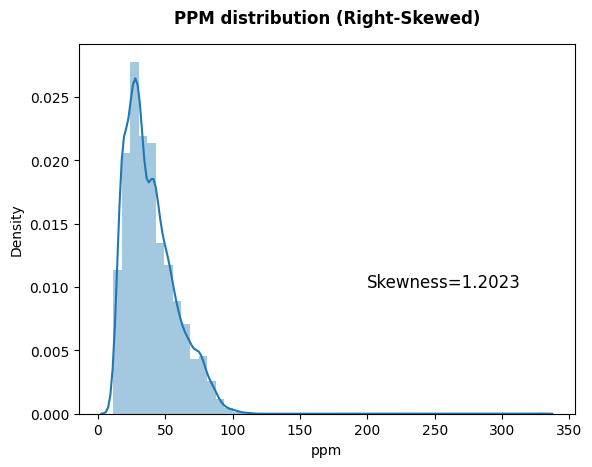

In [197]:
sns.distplot(df.ppm)
plt.title('PPM distribution (Right-Skewed)',fontweight='bold',pad=15)
plt.text(200,0.01,f'Skewness={df.ppm.skew():.4f}',fontsize=12)
plt.show()

In [198]:
df.ppm=np.log(df.ppm)

In [199]:
upper_limit_ppm=df.ppm.mean()+3*df.ppm.std()
lower_limit_ppm=df.ppm.mean()-3*df.ppm.std()

In [200]:
df=df[(df.ppm<upper_limit_ppm) & (df.ppm>lower_limit_ppm)]

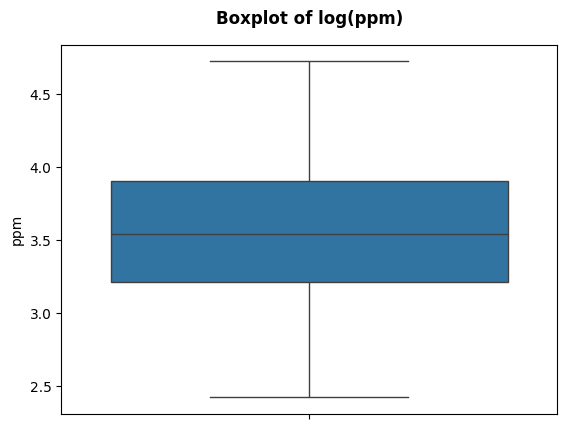

In [201]:
sns.boxplot(df.ppm)
plt.title('Boxplot of log(ppm)',fontweight='bold',pad=15)
plt.show()

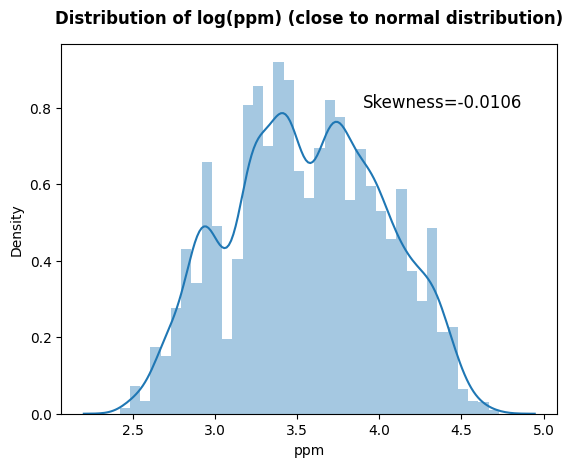

In [202]:
sns.distplot(df.ppm)
plt.title('Distribution of log(ppm) (close to normal distribution)',fontweight='bold',pad=15)
plt.text(3.9,0.8,f'Skewness={df.ppm.skew():.4f}',fontsize=12)
plt.show()

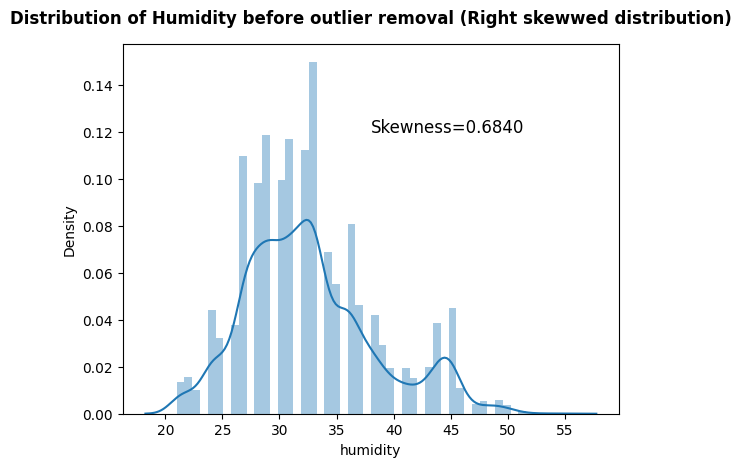

In [203]:
sns.distplot(df.humidity)
plt.title('Distribution of Humidity before outlier removal (Right skewed distribution)',fontweight='bold',pad=15)
plt.text(38,0.12,f'Skewness={df.humidity.skew():.4f}',fontsize=12)
plt.show()

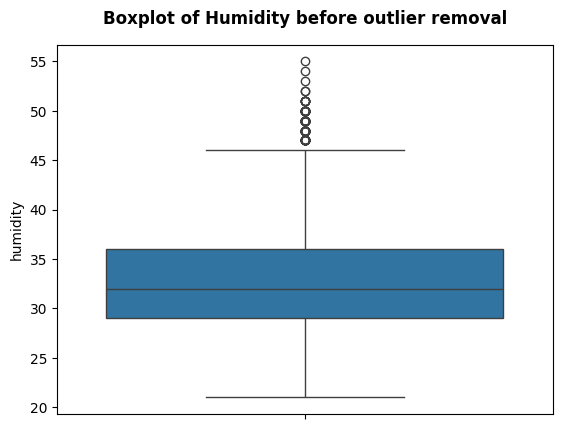

In [204]:
sns.boxplot(df.humidity)
plt.title('Boxplot of Humidity before outlier removal',fontweight='bold',pad=15)
plt.show()

In [205]:
df.humidity.describe()

count    10307.000000
mean        32.617541
std          5.793912
min         21.000000
25%         29.000000
50%         32.000000
75%         36.000000
max         55.000000
Name: humidity, dtype: float64

In [206]:
percentile_25_humidity=29
percentile_75_humidity=36
iqr_hum=percentile_75_humidity-percentile_25_humidity

In [207]:
upper_limit_humidity=percentile_75_humidity+1.5*iqr_hum
lower_limit_humidity=percentile_25_humidity-1.5*iqr_hum

In [208]:
df=df[(df.humidity<upper_limit_humidity) & (df.humidity>lower_limit_humidity)]

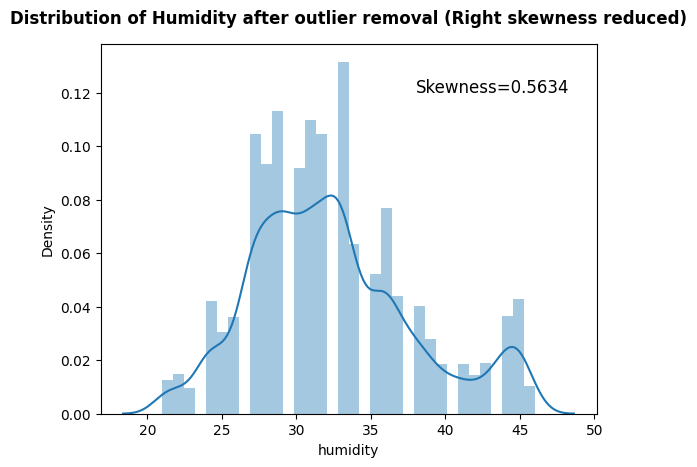

In [219]:
sns.distplot(df.humidity)
plt.title('Distribution of Humidity after outlier removal (Right skewness reduced)',fontweight='bold',pad=15)
plt.text(38,0.12,f'Skewness={df.humidity.skew():.4f}',fontsize=12)
plt.show()

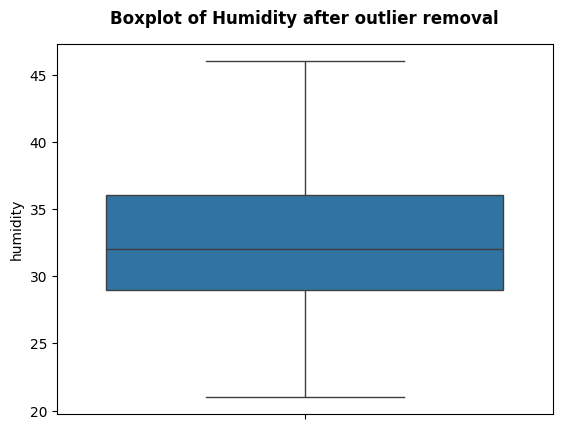

In [210]:
sns.boxplot(df.humidity)
plt.title('Boxplot of Humidity after outlier removal',fontweight='bold',pad=15)
plt.show()

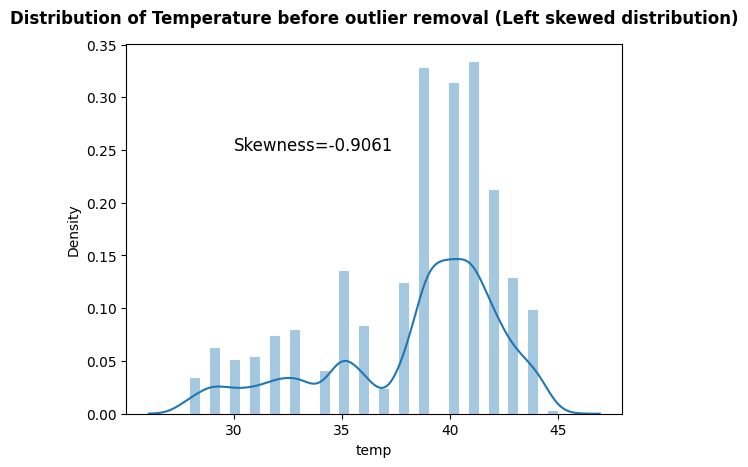

In [211]:
sns.distplot(df.temp)
plt.title('Distribution of Temperature before outlier removal (Left skewed distribution)',fontweight='bold',pad=15)
plt.text(30,0.25,f'Skewness={df.temp.skew():.4f}',fontsize=12)
plt.show()

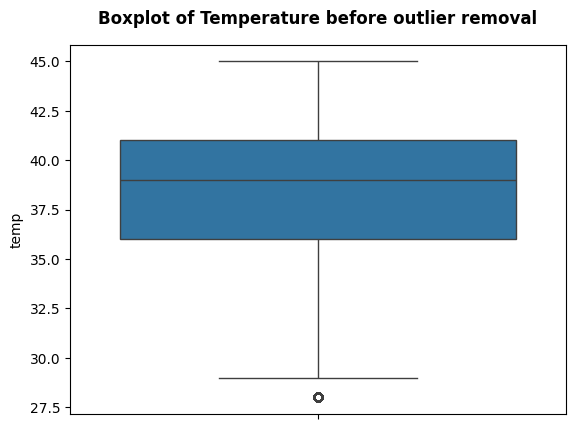

In [212]:
sns.boxplot(df.temp)
plt.title('Boxplot of Temperature before outlier removal',fontweight='bold',pad=15)
plt.show()

In [213]:
df.temp.describe()

count    10162.000000
mean        38.354556
std          4.052256
min         28.000000
25%         36.000000
50%         39.000000
75%         41.000000
max         45.000000
Name: temp, dtype: float64

In [214]:
percentile_25_temp=36
percentile_75_temp=41
iqr_temp=percentile_75_temp-percentile_25_temp

In [215]:
upper_limit_temp=percentile_75_temp+1.5*iqr_temp
lower_limit_temp=percentile_25_temp-1.5*iqr_temp

In [216]:
df=df[(df.temp<upper_limit_temp) & (df.temp>lower_limit_temp)]

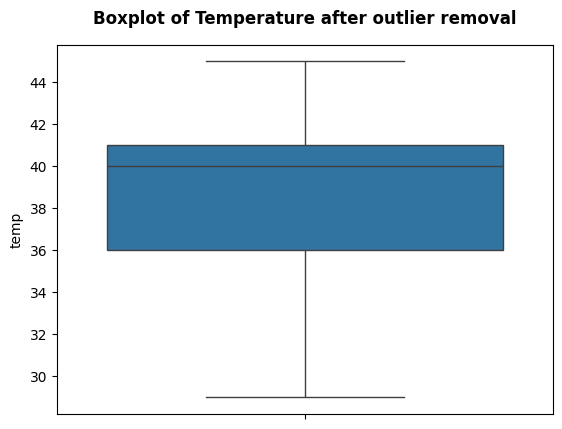

In [217]:
sns.boxplot(df.temp)
plt.title('Boxplot of Temperature after outlier removal',fontweight='bold',pad=15)
plt.show()

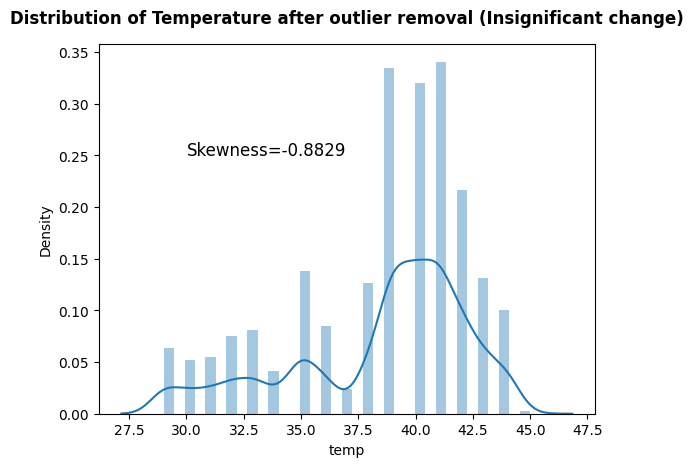

In [220]:
sns.distplot(df.temp)
plt.title('Distribution of Temperature after outlier removal (Insignificant change)',fontweight='bold',pad=15)
plt.text(30,0.25,f'Skewness={df.temp.skew():.4f}',fontsize=12)
plt.show()

In [222]:
df.rename(columns={'ppm':'log_ppm'},inplace=True)

In [223]:
df.sample(5,ignore_index=True)

,temp,humidity,hour,weekend,log_ppm
0,43,30,17,0.0,3.178470
1,41,34,1,0.0,4.214347
2,42,27,17,0.0,2.855320
3,40,34,7,0.0,4.503359
4,29,32,1,1.0,3.246880


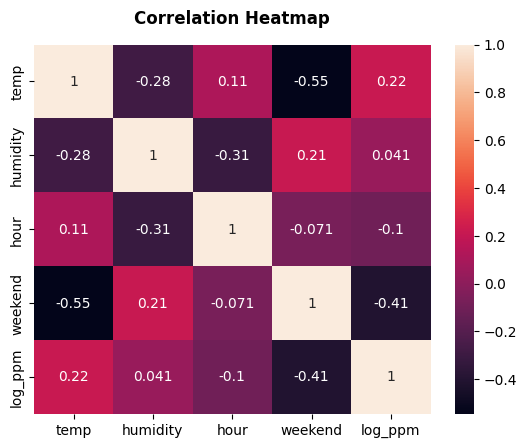

In [224]:
sns.heatmap(df.corr(),annot=True)
plt.title('Correlation Heatmap',fontweight='bold',pad=15)
plt.show()

In [225]:
x=df.drop('log_ppm',axis=1)
y=df['log_ppm']

In [226]:
scaler=StandardScaler()
x=scaler.fit_transform(x)

In [227]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=5)

### Decision Tree (GridSearch CV)

In [228]:
from sklearn.tree import DecisionTreeRegressor

In [229]:
param_grid={
    'criterion' : ['mse','friedman_mse','mae','poisson','squared_error'],
    'max_depth' : [None,5,10,15,20],
    'min_samples_split' : [2,5,10], 
    'min_samples_leaf' : [1,2,4],
    'max_features' : ['auto','sqrt','log2',None]
}

In [230]:
dt_grid_cv=GridSearchCV(estimator=DecisionTreeRegressor(),param_grid=param_grid,scoring='r2',cv=10,n_jobs=-1,verbose=0)

In [231]:
dt_grid_cv.fit(x_train,y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae', 'poisson',
                                       'squared_error'],
                         'max_depth': [None, 5, 10, 15, 20],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='r2')

In [233]:
params=dt_grid_cv.best_params_
params

{'criterion': 'poisson',
 'max_depth': 20,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [235]:
dt=DecisionTreeRegressor(criterion=params['criterion'],max_depth=params['max_depth'],max_features=params['max_features'],
                        min_samples_leaf=params['min_samples_leaf'],min_samples_split=params['min_samples_split'])

In [236]:
model_dt=dt.fit(x_train,y_train)

In [241]:
pred_dt=model_dt.predict(x_test)
print('r2 score:', r2_score(np.exp(y_test),np.exp(pred_dt)),end='  ')
print('MAE:',mean_absolute_error(np.exp(y_test),np.exp(pred_dt)),end='  ')
print('RMSE:', mean_squared_error(np.exp(y_test),np.exp(pred_dt),squared=False))

r2 score: 0.8661211323799313  MAE: 3.613455344230836  RMSE: 6.760563104042347


In [244]:
print('Cross validated r2 scores: ',cross_val_score(model_dt,np.exp(x_test),np.exp(y_test),scoring='r2',cv=10))
print('Mean Cross validated r2 score: ',np.mean(cross_val_score(model_dt,np.exp(x_test),np.exp(y_test),scoring='r2',cv=10)))

Cross validated r2 scores:  [0.82375539 0.84004963 0.8660902  0.82798306 0.85912771 0.84934766
 0.84150027 0.85770637 0.8408787  0.85616982]
Mean Cross validated r2 score:  0.823467246051288


### Neural Network

In [247]:
import tensorflow as tf

In [248]:
model_nn=tf.keras.models.Sequential([
    tf.keras.layers.Dense(64,input_shape=(4,),activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(1)
])
model_nn.compile(optimizer='adam',loss='mean_squared_error')

In [249]:
history=model_nn.fit(x_train,y_train,epochs=200,batch_size=16,validation_split=0.2,verbose=0)

In [250]:
pred_nn=model_nn.predict(x_test)
print('r2 score:', r2_score(np.exp(y_test),np.exp(pred_nn)),end='  ')
print('MAE:',mean_absolute_error(np.exp(y_test),np.exp(pred_nn)),end='  ')
print('RMSE:', mean_squared_error(np.exp(y_test),np.exp(pred_nn),squared=False))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
r2 score: 0.828437244837786  MAE: 4.400413634865193  RMSE: 7.6531171575955135


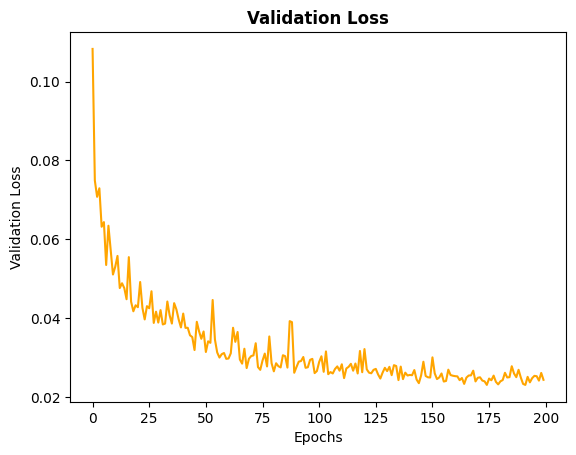

In [251]:
plt.plot(history.history['val_loss'],color='orange')
plt.title('Validation Loss',fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.show()

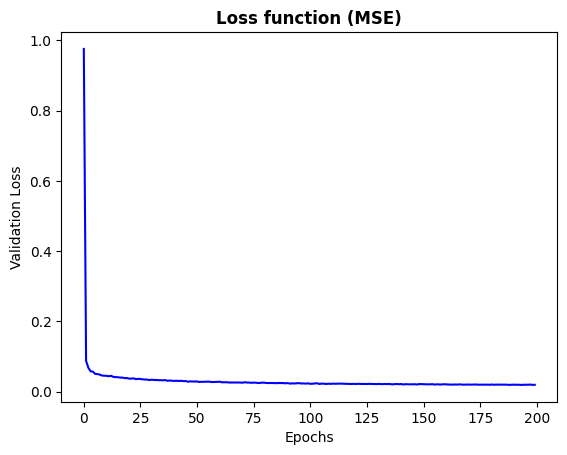

In [253]:
plt.plot(history.history['loss'],color='blue')
plt.title('Loss function (MSE)',fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.show()

### Random Forest (GridSearch CV)

In [254]:
from sklearn.ensemble import RandomForestRegressor

In [255]:
n_estimators=[110,120,130]
max_depth=[10,15,20,25,30]
max_features=[0.2,0.4,0.6,0.8]
max_samples=[0.2,0.4,0.6,0.8]

In [256]:
param_grid={'n_estimators' : n_estimators, 'max_depth' : max_depth, 'max_features' : max_features ,
           'max_samples' : max_samples}

In [257]:
rf_grid_search_cv=GridSearchCV(estimator=RandomForestRegressor(),param_grid=param_grid, 
                               scoring='r2',n_jobs=-1,verbose=0)

In [258]:
rf_grid_search_cv.fit(x_train,y_train)

GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [10, 15, 20, 25, 30],
                         'max_features': [0.2, 0.4, 0.6, 0.8],
                         'max_samples': [0.2, 0.4, 0.6, 0.8],
                         'n_estimators': [110, 120, 130]},
             scoring='r2')

In [259]:
params_rf=rf_grid_search_cv.best_params_
params_rf

{'max_depth': 30, 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 130}

In [260]:
rf=RandomForestRegressor(n_estimators=params_rf['n_estimators'], max_depth=params_rf['max_depth'],
                        max_features=params_rf['max_features'], max_samples=params_rf['max_samples'])

In [261]:
model_rf=rf.fit(x_train,y_train)

In [262]:
pred_rf=model_rf.predict(x_test)
print('r2 score:', r2_score(np.exp(y_test),np.exp(pred_rf)),end='  ')
print('MAE:',mean_absolute_error(np.exp(y_test),np.exp(pred_rf)),end='  ')
print('RMSE:', mean_squared_error(np.exp(y_test),np.exp(pred_rf),squared=False))

r2 score: 0.8708511174658506  MAE: 3.621784681035089  RMSE: 6.640062728133358


In [263]:
print('Cross validated r2 scores: ',cross_val_score(model_rf,np.exp(x_test),np.exp(y_test),scoring='r2',cv=10))
print('Mean Cross validated r2 score: ',np.mean(cross_val_score(model_rf,np.exp(x_test),np.exp(y_test),scoring='r2',cv=10)))

Cross validated r2 scores:  [0.83344062 0.87254269 0.86466341 0.83961697 0.83910783 0.85240917
 0.8349913  0.86222866 0.8413892  0.8405826 ]
Mean Cross validated r2 score:  0.8475738502321333
